# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые перешли на тарифы «Ультра» и «Смарт» (из проекта курса «Статистический анализ данных»). 

<b>Задача проекта:</b> построить модель для задачи классификации, которая выберет подходящий тариф. 

<b>Цель:</b> построить модель с максимально большим значением *accuracy* (0.75). 

<b>Описание данных:</b>

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

<b>План выполнения проекта:</b>

1. Открыть файл с данными и изучить его. 
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследовать качество разных моделей, меняя гиперпараметры. 
4. Проверить качество модели на тестовой выборке.
5. Проверить модели на вменяемость.

## Исходные данные

In [1]:
#загрузим необходимые библиотеки
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [2]:
#Загрузим датасет
pth1 = '/datasets/users_behavior.csv'
pth2 = 'users_behavior.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
    print('platform')
else:
    df = pd.read_csv(pth2)
    print('remote')

platform


In [3]:
#посмотрим на столбцы и данные в них
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


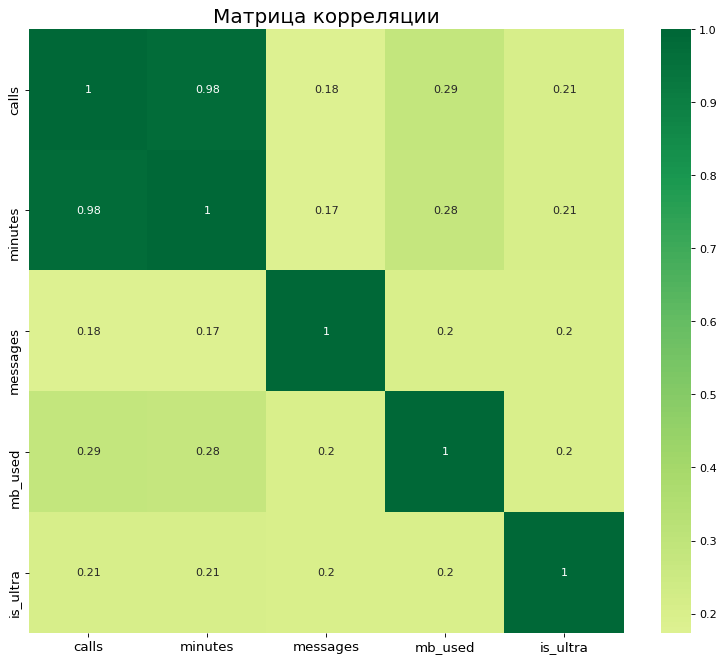

In [5]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Матрица корреляции', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Похоже, что между столбцами 'calls' и 'minutes' существует корреляция. Мультиколлинеарность необходимо исправить на стадии отбора признаков, поскольку наличие коррелирующих параметров может привести к неустойчивости оценок модели. Это грозит тем, что для разных выборок результаты оценок могут сильно отличаться, несмотря на однородность. Для устранения этой проблемы удалим столбец 'calls' из данных.

In [6]:
#удалим столбец 
df = df.drop(['calls'], axis=1)

#посмотрим, что получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   minutes   3214 non-null   float64
 1   messages  3214 non-null   float64
 2   mb_used   3214 non-null   float64
 3   is_ultra  3214 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 100.6 KB


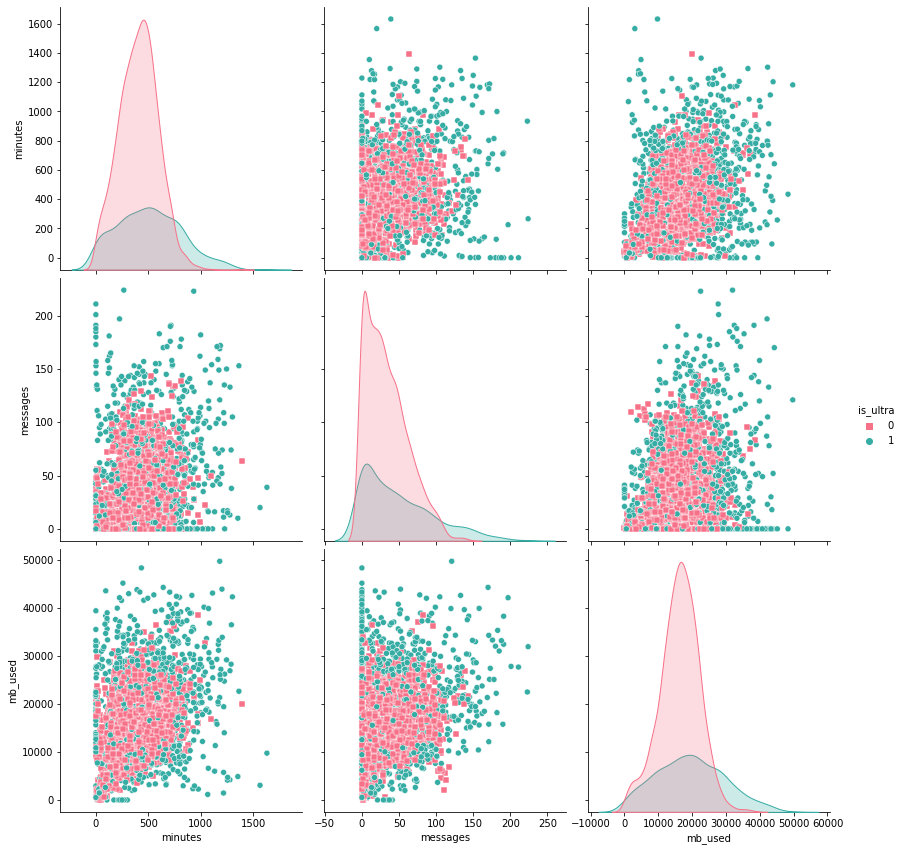

In [7]:
#посмотрим на взаимосвязь параметров для значений целевого столбца
sns.pairplot(df, hue ='is_ultra', height=4, markers=['s', 'o'], palette='husl')
plt.show()

Выше получена матрица парных графиков, отражающих отношения признаков для значений целевого столбца. Судя по главной диагонали, в данных есть существенный перекос в количестве пользователей тарифа "Smart" и "Ultra", приблизительно 1/3. Характер распределения значений в столбцах-признаках достаточно равномерен. Кроме того, для тарифа "Ultra" характерно большее потребление в целом - это интернет-трафик, звонки и сообщения.

Проанализировав полученные данные можно сделать несколько выводов:
1. ключевым показателем является значение в колонке 'is_ultra', отражающее текущий тариф абонента;
2. удален столбец "calls" для исключения мультикорреляции с признаком "minutes";
3. пропуски в данных заполнены, значений распределены нормально, предобработка не требуется;
4. типы данных в столбцах корректны, преобразования не требуются.

## Создание выборок

In [8]:
#зададим признаки
features = df.drop(['is_ultra'], axis=1)

#зададим целевой признак
target = df['is_ultra']

#выделим набор данных для обучающей, валидационной и тестовой выборки в два этапа.
#отделим сначала обучающую выборку, равной 60% от исходных данных
features_train, features_temp, target_train, target_temp = train_test_split(
    features, target, test_size=0.4, random_state=12345)

#далее разделим оставшиеся 40% данных на валидационную и тестовую выборки пополам
features_valid, features_test, target_valid, target_test = train_test_split(
    features_temp, target_temp, test_size=0.5, random_state=12345)

In [9]:
#убедимся, что размер выборок корректен
print(features_train.shape)
print(target_train.shape)
print()
print(features_valid.shape)
print(target_valid.shape)
print()
print(features_test.shape)
print(target_test.shape)

(1928, 3)
(1928,)

(643, 3)
(643,)

(643, 3)
(643,)


При требовании наличия тренировочной, валидационной и тестовой выборки принято делить данные в соотношении 60/20/20. Для контроля воспроизводимости деления выборки был задан параметр <b>random_state<b/>.

## Исследование классических моделей

In [10]:
#Исследуем модель по методу Дерева решений
best_model_tree = None
best_result_tree = 0

for depth in range(1, 6):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной дерева
    model_tree.fit(features_train, target_train) # обучим модель на тренировочной выборке
    predictions_tree = model_tree.predict(features_valid) # получим предсказания модели
    result_tree = accuracy_score(target_valid, predictions_tree) # посчитаем качество модели
    if result_tree > best_result_tree:
        best_model_tree = model_tree # сохраним наилучшую модель
        best_result_tree = result_tree # сохраним наилучшее значение метрики accuracy для предсказания
        best_depth = depth # сохраним наилучшее значение параметра depth
        
print("Accuracy лучшей модели:", best_result_tree)
print("Depth лучшей модели:", best_depth)

Accuracy лучшей модели: 0.7884914463452566
Depth лучшей модели: 4


In [11]:
#Исследуем модель по методу Случайного леса
best_model_forest = None
best_result_forest = 0

for est in range(10, 400, 10):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=est) # обучим модель с заданным количеством деревьев
    model_forest.fit(features_train, target_train) # обучиим модель на тренировочной выборке
    result_forest = model_forest.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
    if result_forest > best_result_forest:
        best_model_forest = model_forest # сохраним наилучшую модель
        best_result_forest = result_forest # сохраним наилучшее значение метрики accuracy на валидационных данных
        best_est = est # сохраним наилучшее значение параметра n_estimators

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest)
print("N_estimators лучшей модели:", best_est)

Accuracy наилучшей модели на валидационной выборке: 0.7838258164852255
N_estimators лучшей модели: 180


In [12]:
#Исследуем модель по методу Логистической регрессии и гиперпараметрами по умолчанию

model_log = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) #обучим модель
model_log.fit(features_train, target_train) # обучим модель на тренировочной выборке
predictions_log = model_log.predict(features_valid) # получим предсказания модели
result_log = accuracy_score(target_valid, predictions_log)  # посчитаем качество модели для предсказания

print("Accuracy наилучшей модели на валидационной выборке:", result_log)

Accuracy наилучшей модели на валидационной выборке: 0.7076205287713841


На данном этапе были исследованны три модели обучения: Дерево решений, Случайный лес и Логистическая регрессия. Эти методы применяются для задачи классификации.

В ходе перебора гиперпараметров, были получены следующие результаты:
1. Дерево решений:
   - точность 79%;
   - глубина дерева (max_depth) - 4.
2. Случайный лес:
   - точность 78%;
   - количество деревьев (n_estimators) - 180.
3. Логистическая регрессия (гиперпараметры по умолчанию):
   - точность 70%
   
Результат для Дерева решений лидирует по точности. 
   
Несмотря на то, что результат точности модели Дерево решений показал лучший результат, для дальнейшей проверки выбрана модель Случайный лес. Эта модель имеет более сложный алгоритм в своей основе и в перспективе может дать лучший результат. 

## Тестирование лучшей модели

In [13]:
#Получим точность для по метода Случайного леса на тестовой выборке

predictions_forest_test = best_model_forest.predict(features_test)
result_forest_test = best_model_forest.score(features_test, target_test) # посчитаем качество модели на тестовой выборке

conf_matrix = pd.DataFrame(confusion_matrix(target_test, predictions_forest_test), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])

print('Accuracy наилучшей модели на тестовой выборке', result_forest_test)
conf_matrix

Accuracy наилучшей модели на тестовой выборке 0.7931570762052877


,predicted 0,predicted 1
actual 0,394,46
actual 1,87,116


В результате проверки модели на тестовой выборке точность оказалась немного лучше - 0.793 против 0.783 на валидационной выборке. Такой результат может считаться успешным, поскольку целевой показатель точности был достигнут (не меньше 0.75). 

Судя по матрице ошибок, модель неверно предсказала значения в 46 случая для тарифа "Смарт" и в 87 случаях для тарифа "Ультра", что достаточно много.  

## Проверка модели на адекватность

Первым этапом проверим исходные данные, используя наиболее простой фиктивный классификатор. Такая модель предсказывает наиболее часто встречающийся класс. Считается, что контрольные данные будут хуже, чем результаты любой другой сложной модели.

In [14]:
#Исследуем константную модель 

baseline = DummyClassifier(strategy="most_frequent", random_state=0) #зададим параметры модели

baseline.fit(features_train, target_train) #обучим модель

result_base = baseline.score(features_test, target_test) #получим точность предсказаний на тестовой выборке

print("Accuracy константной модели:", result_base)

Accuracy константной модели: 0.6842923794712286


Значение точности не удовлетворяет цели - 0.75. Это значит, что использование более сложных моделей целесообразно.

Далее сравним точность всех моделей на тестовой выборке.

In [15]:
# Проверим остальные модели на тестовой выборке

predictions_tree_test = best_model_tree.predict(features_test) #получим предсказание для модели Дерево решений
result_tree_test = accuracy_score(target_test, predictions_tree_test) # посчитаем качество модели на тестовой выборке

predictions_log_test = model_log.predict(features_test) #получим предсказание для модели Логистическая регрессия
result_log_test = accuracy_score(target_test, predictions_log_test) # посчитаем качество модели на тестовой выборке

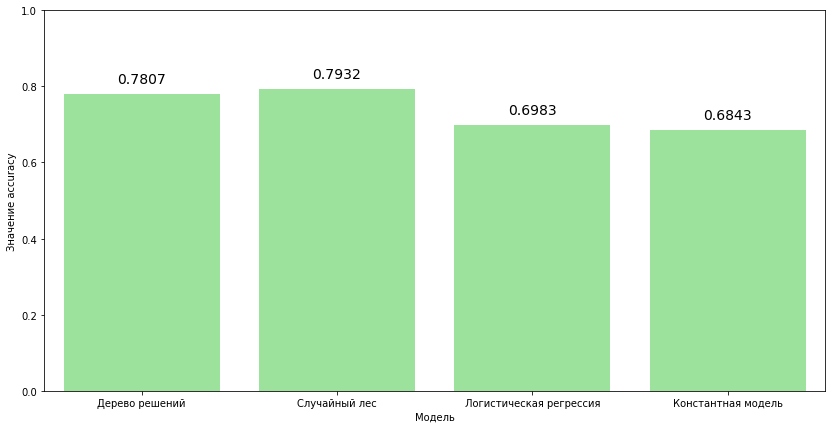

In [16]:
#выводим диаграмму сравнения моделей по значению точности по результатам тестовой выборки

#зададим названия столбцов для нового датафрейма
column = ['Модель', 'Значение accuracy']

#создадим датафрейм с результатами
acc_data = (
    [['Дерево решений', result_tree_test],
     ['Случайный лес', result_forest_test],
     ['Логистическая регрессия', result_log_test],
     ['Константная модель', result_base]])

acc_com = pd.DataFrame(data=acc_data, columns=column)

#зададим размер диаграммы
plt.figure(figsize=(14, 7))

#создадим столбчатую диаграмму 
acc_bar = sns.barplot(x="Модель", y="Значение accuracy", data=acc_com, color='lightgreen')

# Создадим метки с значениями точности для каждой модели
for bar in acc_bar.patches:
    acc_bar.annotate(format(bar.get_height(), '.4f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=14, xytext=(0, 15),
                   textcoords='offset points')

#Зададим настройки для лучшего отображения и выведем диаграмму
acc_bar.set_ylim(0,1)
plt.rcParams['font.size'] = "14"
plt.show()

Один из показателей для проверки адекватности модели - точность. Чем точность ближе к 1, тем лучше модель способна делать предсказания. По результатам проверки моделей на тестовой выборке самой лучшей по показателю точности - модель Случайный лес с подобранным гиперпараметром количества деревьев. Наименее точные предсказания получены для модели логистической регрессии, результаты которой близки к константной. 

## Выводы


По результатам исследования была выполнена задача по построению модели для задачи классификации, которая способна подобрать
подходящий тариф. 

Цель исследования достигнута. В результате обучена модель по методу "Случайный лес" с гиперпараметром *n_estimators* - 180 и значением *accuracy* - 0.79. Сравнение с результатами константной модели показало большую разницу в точности, что говорит об адекватности обученной модели Случайный лес.

Выполнены следующие этапы:
1. Изучены исходные данные; 
2. Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 60/20/20;
3. Исследованы качество разных моделей и получены следующие результаты:
    - Дерево решений с точностью 79% и глубиной дерева (max_depth) - 4;
    - Случайный лес с точностью 78% и количеством деревьев (n_estimators) - 180;
    - Логистическая регрессия (гиперпараметры по умолчанию) с точностью 70%.
4. Качество моделей проверено на тестовой выборке и получены следующие результаты:
    - Дерево решений - точность 78%;
    - Случайный лес - точность 79%;
    - Логистическая регрессия - точность 70%.
5. Выполнено тестирование модели с фиктивным классификатором. Результаты точности константной модели - 0.68, что ниже целевого значения 0.75.
